In [6]:
import pandas as pd

import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2

from src.annotation_loader import Phase1Loader
from tqdm import tqdm


In [7]:
from glob import glob 

files = glob("../data/annotation_output/annotations_metadata/*.csv")

#### Load all the necessary annotation data and metadata

In [8]:
def concatenate_metadata(file_list):
	"""
	Concatenate multiple Excel files into a single DataFrame.
	
	Parameters:
	- file_list: List of strings where each string is a path to an Excel file.
	
	Returns:
	- A Pandas DataFrame containing the concatenated data from all provided Excel files.
	"""
	# List to store individual DataFrames
	dataframes = []

	# Iterate over the list of files
	for file_path in file_list:
		# Load each Excel file into a DataFrame
		df = pd.read_csv(file_path, dtype={"Conversation ID": str})
		# Append the DataFrame to the list
		dataframes.append(df)

	# Concatenate all DataFrames in the list
	concatenated_df = pd.concat(dataframes, ignore_index=True)
	
	return concatenated_df

In [9]:
df = concatenate_metadata(files)

In [10]:
df.head()

,Conversation ID,Time Taken,Conversational Friction (Y/N),Conversational Success,Ending,Type,Unnamed: 6,Comments
0,93.1,18 minutes,Yes,Some Progress,Conversation had a natural End,Type 1,NaN,NaN
1,77.3,16 minutes,Yes,Success,Conversation had a natural End,Type 1,NaN,NaN
2,75.1,17 minutes,No,Some Progress,Conversation Ended Abruptly,Type 1,NaN,NaN
3,74.1,9 minutes,No,Some Progress,Conversation had a natural End,Type 1,NaN,NaN
4,67.1,8 minutes,Yes,Some Progress,Conversation had a natural End,Type 1,NaN,NaN


### Clean the annotations for analysis

In [11]:
df = df.dropna(how="all")
df['conv_length'] = df['Conversation ID'].astype(str).str.split('.').str[0]
# make conv_length an int type after removing rows where the value is 'nan' 
df = df[df['conv_length'] != 'nan']
df['conv_length'] = df['conv_length'].astype(int)
df['Conversation ID'] = df['Conversation ID'].astype(str)

# rename columns for easier access
rename_dict = {
	"Conversation ID": "conv_id",
	'Conversational Friction (Y/N) ': "friction", 
	'Conversational Success ': "success",
}

df = df.rename(columns=rename_dict)

# convert the column "Conversational Friction (Y/N)" to a boolean type for analysis
df['friction'] = df['friction'].map({"Yes": True,
									"No": False})

df['success'] = df['success'].map({"Success": 3, "Some Progress": 2, "No Progress": 1})


In [73]:
df.head()

,conv_id,Time Taken,friction,success,Ending,Type,Unnamed: 6,Comments,conv_length
0,93.1,18 minutes,True,2,Conversation had a natural End,Type 1,NaN,NaN,93
1,77.3,16 minutes,True,3,Conversation had a natural End,Type 1,NaN,NaN,77
2,75.1,17 minutes,False,2,Conversation Ended Abruptly,Type 1,NaN,NaN,75
3,74.1,9 minutes,False,2,Conversation had a natural End,Type 1,NaN,NaN,74
4,67.1,8 minutes,True,2,Conversation had a natural End,Type 1,NaN,NaN,67


In [69]:
df.shape

(200, 9)

In [55]:
df.friction.value_counts(normalize=True)

friction
True     0.545
False    0.455
Name: proportion, dtype: float64

In [70]:
df['success'].value_counts(normalize=True)

success
2    0.445
3    0.295
1    0.260
Name: proportion, dtype: float64

In [13]:
# define an empty column for the number of friction points
loader = Phase1Loader()

num_friction = []
friction_present = 0 
friction_lengths = []
non_friction_lengths = []

for i, row in tqdm(df.iterrows()):
	
	conv_id = row['conv_id']
	num_frictions = len(loader.get_annotation_data(conv_id)['friction_turns']) 
	
	conv_length = int(float(conv_id))
	if num_frictions > 0:
		friction_present += 1
		friction_lengths.append(conv_length)
	else:
		non_friction_lengths.append(conv_length)


	num_friction.append(num_frictions)
	

200it [00:15, 13.00it/s]


Median length of conversations with and without friction. Overall mean = 40.56, median= 33

In [14]:
import numpy as np
np.mean(friction_lengths), np.median(friction_lengths)

(48.74311926605505, 55.0)

In [15]:
np.mean(non_friction_lengths), np.median(non_friction_lengths)

(28.978021978021978, 22.0)

In [16]:
friction_present / 200 * 100 

54.50000000000001

In [17]:
df['num_friction'] = num_friction

In [18]:
len(num_friction)

200

In [19]:
df.head()

,conv_id,Time Taken,friction,success,Ending,Type,Unnamed: 6,Comments,conv_length,num_friction
0,93.1,18 minutes,True,2,Conversation had a natural End,Type 1,NaN,NaN,93,3
1,77.3,16 minutes,True,3,Conversation had a natural End,Type 1,NaN,NaN,77,1
2,75.1,17 minutes,False,2,Conversation Ended Abruptly,Type 1,NaN,NaN,75,0
3,74.1,9 minutes,False,2,Conversation had a natural End,Type 1,NaN,NaN,74,0
4,67.1,8 minutes,True,2,Conversation had a natural End,Type 1,NaN,NaN,67,1


### Other Analyses for Section 4.1 below

In [32]:
df.groupby('success')['num_friction'].mean()

success
1    1.403846
2    1.134831
3    1.084746
Name: num_friction, dtype: float64

In [33]:
df.groupby('success')['num_friction'].value_counts(normalize=True)

success  num_friction
1        0               0.423077
         1               0.230769
         2               0.153846
         3               0.096154
         4               0.038462
         11              0.019231
         6               0.019231
         5               0.019231
2        0               0.449438
         1               0.235955
         2               0.146067
         3               0.112360
         4               0.033708
         5               0.011236
         7               0.011236
3        0               0.491525
         1               0.271186
         2               0.101695
         5               0.050847
         3               0.033898
         4               0.033898
         7               0.016949
Name: proportion, dtype: float64

In [34]:
df_friction = df[df['num_friction'] > 0]

df_friction.groupby('success')['num_friction'].mean()

success
1    2.433333
2    2.061224
3    2.133333
Name: num_friction, dtype: float64

In [35]:
df_friction.shape

(109, 10)

In [36]:
df.groupby('success')['conv_length'].agg(['mean', 'std'])

,mean,std
success,,
1,31.903846,24.995890
2,43.865169,25.736511
3,40.457627,28.841016


In [37]:
# find correlation between the columns success and friction 
# find the distribution of friction for each value of success 
df.groupby('success')[['friction']].value_counts(normalize=False)

success  friction
1        True        30
         False       22
2        True        49
         False       40
3        True        30
         False       29
Name: count, dtype: int64

In [38]:
df['success'].value_counts()

success
2    89
3    59
1    52
Name: count, dtype: int64

In [39]:
df.groupby('success')[['friction']].value_counts(normalize=True)

success  friction
1        True        0.576923
         False       0.423077
2        True        0.550562
         False       0.449438
3        True        0.508475
         False       0.491525
Name: proportion, dtype: float64

In [40]:
df['Ending']  = df['Ending'].str.lower()

In [41]:
df['Ending'].value_counts(normalize=True)

Ending
conversation had a natural end                                  0.550
conversation ended abruptly                                     0.315
someone ran out of time                                         0.095
other                                                           0.025
conversation ended abruptly, conversation had a natural end     0.005
conversation had a natural end                                  0.005
conversation had a natural end , conversation ended abruptly    0.005
Name: proportion, dtype: float64

In [42]:
df.groupby('success')[['Ending']].value_counts(normalize=True)

success  Ending                                                      
1        conversation ended abruptly                                     0.557692
         conversation had a natural end                                  0.250000
         someone ran out of time                                         0.115385
         other                                                           0.057692
         conversation had a natural end                                  0.019231
2        conversation had a natural end                                  0.494382
         conversation ended abruptly                                     0.359551
         someone ran out of time                                         0.123596
         conversation ended abruptly, conversation had a natural end     0.011236
         other                                                           0.011236
3        conversation had a natural end                                  0.898305
         conversation ended 

In [43]:
# find the distribution of success over friction and conv_length
df.groupby('friction').agg({'success': 'mean', 'conv_length': 'mean'})

,success,conv_length
friction,,
False,2.076923,28.978022
True,2.000000,48.743119


In [30]:
(19 / 33 ) * 100, (66 / (48 + 39))

(57.57575757575758, 0.7586206896551724)

In [26]:
df.groupby('success').agg({'conv_length': 'mean'})

,conv_length
success,
1,34.000000
2,45.145833
3,41.666667


In [54]:
df.groupby('friction').agg({'conv_length': ['mean', 'std', 'median']})


conv_length                  
                mean        std median
friction                              
False      25.397436  21.207901   16.5
True       48.926230  26.058157   54.0

In [39]:
df.conv_length.mean(), df.conv_length.std(), df.conv_length.median()

(40.56666666666667, 27.650195900451287, 33.0)

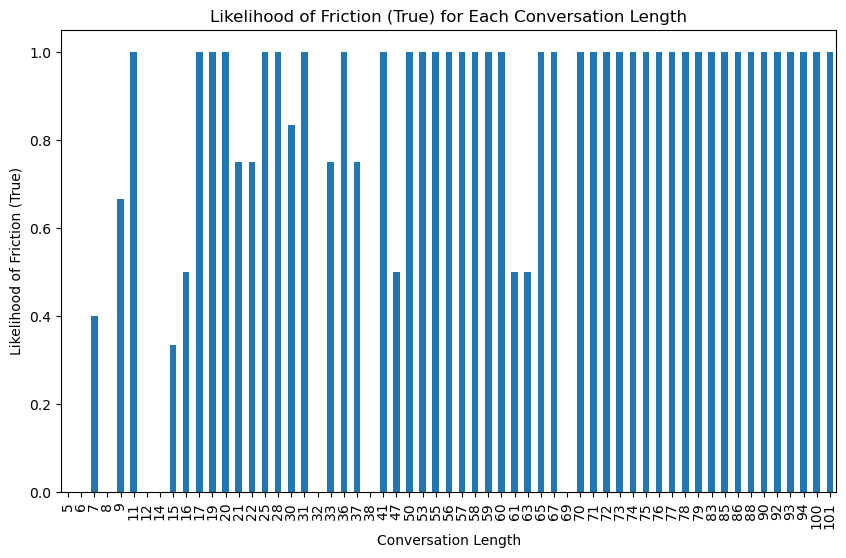

In [42]:
import matplotlib.pyplot as plt

# Calculate the likelihood of friction being True for each value of conv_length
friction_likelihood = df.groupby('conv_length')['friction'].mean()

# Plot the likelihood
plt.figure(figsize=(10, 6))
friction_likelihood.plot(kind='bar')
plt.xlabel('Conversation Length')
plt.ylabel('Likelihood of Friction (True)')
plt.title('Likelihood of Friction (True) for Each Conversation Length')
plt.show()